In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.optimize import OptimizeResult
from concurrent.futures import ProcessPoolExecutor

In [24]:
def compute_bellow_moment_force(p, R_outer, r_inner, n_bellow):
    """Approximate the total force and moment from the bellow structure. Approximate bellow
    structure area.

    Args:
        p (float): Pressure in Pa
        R_outer (float): Outer radius of the bellow in mm
        r_inner (float): Inner radius of the bellow in mm
        n_bellow (np.array): Number of bellows in the structure
    """
    # Reshape n_bellow to column vector
    n_bellow = n_bellow.reshape(-1, 1)
    # Effective area of a single bellow - hollow semicircle with radius R_outer and r_inner
    A_bellow = np.pi * (R_outer**2 - r_inner**2) / 2
    # Total force from bellow structure
    F_bellow = n_bellow * p * A_bellow
    # Total moment from bellow structure
    M_bellow = 2/3 * n_bellow * p * (R_outer**3 - r_inner**3)

    return A_bellow, F_bellow, M_bellow

def calculate_stiffness_hollow_semicircular_annulus_thick(L, E, R_out, r_in, t):
    ###### Fourth set of equations corresponds to Hollow semicircular annulus with 
    # thickened rectangular element below

    # Area of the semicirular annulus
    A_semi = np.pi * (R_out**2 - r_in**2) / 2
    # Area of the rectangular base width 2R_out and height t
    A_rect = 2 * R_out * t

    # Area moment of inertia of the semicircular annulus
    I_semi = np.pi / 8 * (R_out**4 - r_in**4)
    # Area moment of inertia of the rectangular base
    I_rect_centroid = 1/12 * 2 * R_out * t**3
    # Parallel axis theorem to calculate I_rect about upper edge (base)
    I_rect = I_rect_centroid + A_rect * (t / 2)**2
    # Total area moment of inertia about upper edge (base)
    I_total = I_semi + I_rect

    # Centroid of the semicircular annulus from the base
    # y_semi = 4 / 3 / np.pi * (R_out**3 - r_in**3) / (R_out**2 - r_in**2)
    # Centroid of the composite shape from the base
    # y_total = (A_semi * y_semi + A_rect * (- t / 2)) / (A_semi + A_rect)
    # Total area moment of inertia about centroid (lower than about base)
    # I_total_centroid = I_total + (A_semi + A_rect) * y_total**2

    # Stifness - in L direction for elongation E * A / L
    Cz = E / L * (A_semi + A_rect) # F / delta_x

    # Rotational stiffness
    # Ky = E / L * (np.pi / 8 * (R_out**4 - r_in**4) + 2 / 3 * R_out * t**3)  # M / delta_theta_y
    # Ky = E / L * I_total_centroid # M / delta_theta_y
    Ky = E / L * I_total # M / delta_theta_y

    return A_semi, A_rect, I_semi, I_rect, I_total, Cz, Ky

def compute_prb_params_end_moment(
    E_I_div_L, M_acting, gamma_characteristic_radius_factor, L_initial_length, 
    c_theta_parametric_angle_coefficient, quadratic_correction_term
    ):
    # We can skip computing stifness of equivalent torsional spring, as the terms cancel out
    # for end-moment calculation
    # Beam end angular deflection
    # Add correction quadratic term to account for small nonlinearities
    theta_end_angular_deflection = (
        M_acting / E_I_div_L * (1 + quadratic_correction_term * M_acting / E_I_div_L)
        )
    # Coordinates of the end of deflected beam
    x_end = (
        (1 - gamma_characteristic_radius_factor) * L_initial_length +
        gamma_characteristic_radius_factor * L_initial_length * 
        np.cos(theta_end_angular_deflection/c_theta_parametric_angle_coefficient)
        )
    y_end = (
        gamma_characteristic_radius_factor * L_initial_length * 
        np.sin(theta_end_angular_deflection/c_theta_parametric_angle_coefficient)
        )
    return theta_end_angular_deflection, x_end, y_end

def compute_prb_joint_start_coord(
    x_prev_joint_end, y_prev_joint_end, inter_joint_dist,
    theta_prev_joint_cumulative
    ):
    x_joint_start = x_prev_joint_end + inter_joint_dist * np.cos(theta_prev_joint_cumulative)
    y_joint_start = y_prev_joint_end + inter_joint_dist * np.sin(theta_prev_joint_cumulative)
    return x_joint_start, y_joint_start

def compute_prb_joint_end_coord(
    x_joint_start, y_joint_start, joint_end_rel_x, joint_end_rel_y, 
    theta_prev_joint_cumulative, delta_l_joint_elongation, theta_joint_cumulative
    ):
    x_joint_end = (
        x_joint_start + joint_end_rel_x * np.cos(theta_prev_joint_cumulative) -
        joint_end_rel_y * np.sin(theta_prev_joint_cumulative) +
        delta_l_joint_elongation * np.cos(theta_joint_cumulative)
    )
    y_joint_end = (
        y_joint_start + joint_end_rel_y * np.cos(theta_prev_joint_cumulative) +
        joint_end_rel_x * np.sin(theta_prev_joint_cumulative) +
        delta_l_joint_elongation * np.sin(theta_joint_cumulative)
        )
    return x_joint_end, y_joint_end


#### Optimizazion of PRB model - END MOMENT LOADING

In [3]:
# Parametric angle coefficient
c_theta = 1.5164
# Young's modulus for TPU 85A in Mpa
E = 27
# Length of all three bellow segments in mm
L0 = np.array([31, 21, 21])
# Diameters in mm - reinforced and unreinforced
d_hole = 6
D_bellow_out = 22
d_bellow_in = 7.85
# Thickness of bottom layer in mm
t = (2.5 + 4.7) / 2

pressure = np.linspace(0, 0.7, 8)  # Internal pressure (MPa)
# Remove thickness of the bellow from R_outer, and add it to r_inner (+0.9 due to geometry)
R_outer = 15.5 - 0.8  # Outer diameter of bellow (mm) - 15.5 is from thick element to top
r_inner = d_bellow_in + 0.575  # Inner diameter of bellow (mm)
n_bellow = np.array([7, 5, 5])  # Number of bellows

# Load experimental data
experiment_data = pd.read_csv('kinematics/Hand9DOF/Index/data/soft_robot_experiment_results.csv')
# Extract only index finger delta_z exparimental
delta_z_exp = experiment_data[experiment_data['finger'] == 'index'].dropna()[['d_1_3', 'd_3_5', 'd_5_7']].values.T
delta_theta_y_exp_rep1 = experiment_data.loc[(experiment_data['finger'] == 'index') & (experiment_data['rep'] == 1)][['theta2', 'theta4', 'theta6']].values.T
delta_theta_y_exp_rep2 = experiment_data.loc[(experiment_data['finger'] == 'index') & (experiment_data['rep'] == 2)][['theta2', 'theta4', 'theta6']].values.T

def compute_angle_displacement_nrmse(
    lmbd, gamma, pressure, R_outer, r_inner, n_bellow, L0, E, d_hole, D_bellow_out, d_bellow_in, t,
    c_theta, delta_z_exp, delta_theta_y_exp_rep1, delta_theta_y_exp_rep2
    ):
    # Compute single bellow area, force and moment
    A_bellow, F_bellow, M_bellow = compute_bellow_moment_force(
        pressure*gamma, R_outer, r_inner, n_bellow
        )
    # Calculate equivalent diameter
    D_bellow_out_equivalent = lmbd * D_bellow_out + (1 - lmbd) * d_bellow_in
    # Calculate stiffness
    _, _, _, _, I_total, Cz, _ = calculate_stiffness_hollow_semicircular_annulus_thick(
        L0, E, D_bellow_out_equivalent / 2, d_hole / 2, t
        )
    # Compute elongation
    delta_z = F_bellow / Cz[:, np.newaxis] 
    # Torsional spring constant - for end moment gamma_pivot * K_theta = c_theta
    K = c_theta * E * I_total / L0
    # Calculate pivot angle
    delta_theta_pivot = M_bellow / K[:, np.newaxis]
    # Calculate angle displacement
    delta_theta_y = delta_theta_pivot * c_theta * 180 / np.pi
    # Calculate sd normalized root mean square errors
    delta_z_rmse = np.sqrt(np.mean(np.square(delta_z_exp - delta_z)))
    delta_z_nrmse = delta_z_rmse / delta_z_exp.std()
    delta_theta_y_rmse_rep1 = np.sqrt(np.mean(np.square(delta_theta_y_exp_rep1 - delta_theta_y)))
    delta_theta_y_rmse_rep2 = np.sqrt(np.mean(np.square(delta_theta_y_exp_rep2 - delta_theta_y)))
    delta_theta_y_nrmse_rep1 = delta_theta_y_rmse_rep1 / delta_theta_y_exp_rep1.std()
    delta_theta_y_nrmse_rep2 = delta_theta_y_rmse_rep2 / delta_theta_y_exp_rep2.std()
    return delta_z_nrmse, (delta_theta_y_nrmse_rep1 + delta_theta_y_nrmse_rep2) / 2

def obj_func_single_param(x):
    # print(x)
    lmbd = x[[0, 1, 1]]
    gamma = x[2:].reshape(-1, 1)
    delta_z_nrmse, delta_theta_y_nrmse = compute_angle_displacement_nrmse(
        lmbd, gamma, pressure, R_outer, r_inner, n_bellow, L0, E, d_hole, D_bellow_out, d_bellow_in, t,
        c_theta, delta_z_exp, delta_theta_y_exp_rep1, delta_theta_y_exp_rep2
        )
    return (delta_z_nrmse + delta_theta_y_nrmse) / 2

obj_func_single_param(np.array([0.65, 0.65, 1.0, 1.0, 1.0]))


optim_res = scipy.optimize.brute(
    func=obj_func_single_param,
    ranges=(
        # lambda range from 0.2 to 0.9 with step 0.05,
        slice(0.5, 0.98, 0.05), slice(0.5, 0.9, 0.05),
        # gamma from 0.6 to 1.4 with step 0.05
        slice(0.1, 1.0, 0.05), slice(0.1, 1.0, 0.05), slice(0.1, 1.0, 0.05)),
    full_output=True,
    # finish=None,
    finish=scipy.optimize.fmin,
    workers=-1
    )
# Plot only parameters and objective function value
optim_res[:2]

(array([1.32207878, 1.33774712, 1.41847906, 2.79471008, 3.51588913]),
 0.21620713608372805)

In [4]:
print(f'Grid minimum NRMSE: {optim_res[3].min()}')
min_ind = np.unravel_index(optim_res[3].argmin(), optim_res[3].shape)

Grid minimum NRMSE: 0.5773547291905063


In [5]:
print(f'Grid optimal params: {optim_res[2][(slice(None),) + min_ind]}')

Grid optimal params: [0.95 0.8  0.65 0.8  0.95]


#### Hollow Semicircular Annulus and rectangular base

In [6]:
# Young's modulus for TPU 85A in Mpa
E = 27
# Length of all three bellow segments in mm
L0 = np.array([31, 21, 21])
# Diameters in mm - reinforced and unreinforced
d_hole = 6
D_bellow_out = 22
d_bellow_in = 7.85
# Thickness of bottom layer in mm - use average of min and max measured
t = 2.5 
# Equivalent diameter to reduce the cross-section surface area - not full material
# Use lmbd as a mixing parameter betweeen D_bellow_out and d_bellow_in
# lmbd = np.array([0.94, 0.74, 0.74]) # Works for maximum pressure of 3 bar
lmbd = np.array([1.17972463, 1.19480546, 1.19480546]) # Works for maximum pressure of 3 bar
# lmbd = 0.65
D_bellow_out_equivalent = lmbd * D_bellow_out + (1 - lmbd) * d_bellow_in

# Area of the semicirular annulus
# Area of the rectangular base width D_bellow_out_equivalent and height t
# Area moment of inertia of the semicircular annulus
# Area moment of inertia of the rectangular base
# Parallel axis theorem to calculate I_rect about upper edge (base)
# Total area moment of inertia
# Rotational stifness about y-axis
A_semi, A_rect, I_semi, I_rect, I_total, Cz, Ky = calculate_stiffness_hollow_semicircular_annulus_thick(
    L0, E, D_bellow_out_equivalent / 2, d_hole / 2, t
    )

# Print all dimensions and design parameters
print("Lengths")
print(f'L0 = {L0} mm')
print('Diameters')
print(f'D_bellow_out = {D_bellow_out} mm')
print(f'd_bellow_in = {d_bellow_in} mm')
print(f'd_hole = {d_hole} mm')
print('Thickness')
print(f't = {t} mm')
print('Equivalent Parameters')
print(f'lambda = {lmbd}')
print(f'D_bellow_out_equivalent = {D_bellow_out_equivalent} mm')
print('Areas')
print(f'A_semi = {A_semi} mm^2')
print(f'A_rect = {A_rect} mm^2')
print('Area moment of inertia')
print(f'I_semi = {I_semi} mm^4')
print(f'I_rect = {I_rect} mm^4')
print(f'I_total = {I_total} mm^4')
print('Material Properties')
print(f'E = {E} MPa')
print("Stiffness")
print(f'Cz = {Cz} N/mm')
print('Rotational Stiffness')
print(f'Ky = {Ky} Nmm/rad')

Lengths
L0 = [31 21 21] mm
Diameters
D_bellow_out = 22 mm
d_bellow_in = 7.85 mm
d_hole = 6 mm
Thickness
t = 2.5 mm
Equivalent Parameters
lambda = [1.17972463 1.19480546 1.19480546]
D_bellow_out_equivalent = [24.54310351 24.75649726 24.75649726] mm
Areas
A_semi = [222.41059527 226.54187852 226.54187852] mm^2
A_rect = [61.35775879 61.89124315 61.89124315] mm^2
Area moment of inertia
I_semi = [8873.68135597 9187.46473512 9187.46473512] mm^4
I_rect = [127.82866414 128.94008989 128.94008989] mm^4
I_total = [9001.51002011 9316.40482501 9316.40482501] mm^4
Material Properties
E = 27 MPa
Stiffness
Cz = [247.15308256 370.842585   370.842585  ] N/mm
Rotational Stiffness
Ky = [ 7840.02485623 11978.23477501 11978.23477501] Nmm/rad


#### Bending moment and axial force approximation from pressure

In [7]:
pressure = np.linspace(0, 0.7, 8)  # Internal pressure (MPa)
# Remove thickness of the bellow from R_outer, and add it to r_inner (+0.9 due to geometry)
R_outer = 15.5 - 0.8  # Outer diameter of bellow (mm) - 15.5 is from thick element to top
r_inner = d_bellow_in + 0.575  # Inner diameter of bellow (mm)
n_bellow = np.array([7, 5, 5])  # Number of bellows
# gamma = np.array([1.36 , 1.44 , 1.96])[:, np.newaxis] # Pressure adjustment
gamma = np.array([2.3369788 , 4.61432697, 5.80510008])[:, np.newaxis] # Pressure adjustment
pressure_adj = pressure * gamma


print(f'pressure p = {pressure} MPa')
print(f'R_outer = {R_outer} mm')
print(f'r_inner = {r_inner} mm')
print(f'n_bellow: {n_bellow}')
A_bellow, F_bellow, M_bellow = compute_bellow_moment_force(pressure_adj, R_outer, r_inner, n_bellow)
print(f"A_bellow = {A_bellow} mm^2")
print('F_bellow [N]')
print(F_bellow)
print("M_bellow [Nmm]")
print(M_bellow)

pressure p = [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7] MPa
R_outer = 14.7 mm
r_inner = 8.424999999999999 mm
n_bellow: [7 5 5]
A_bellow = 227.9372732335032 mm^2
F_bellow [N]
[[   0.          372.87920269  745.75840539 1118.63760808 1491.51681077
  1864.39601347 2237.27521616 2610.15441885]
 [   0.          525.88855367 1051.77710735 1577.66566102 2103.5542147
  2629.44276837 3155.33132205 3681.21987572]
 [   0.          661.59934154 1323.19868308 1984.79802462 2646.39736617
  3307.99670771 3969.59604925 4631.19539079]]
M_bellow [Nmm]
[[    0.          2812.09884214  5624.19768428  8436.29652641
  11248.39536855 14060.49421069 16872.59305283 19684.69189497]
 [    0.          3966.03131041  7932.06262082 11898.09393122
  15864.12524163 19830.15655204 23796.18786245 27762.21917286]
 [    0.          4989.50525765  9979.0105153  14968.51577295
  19958.0210306  24947.52628825 29937.0315459  34926.53680355]]


#### Pseudo-Rigid-Body Models for Planar Beams - END-MOMENT LOADING

[11888.61369198 18163.79521282 18163.79521282]


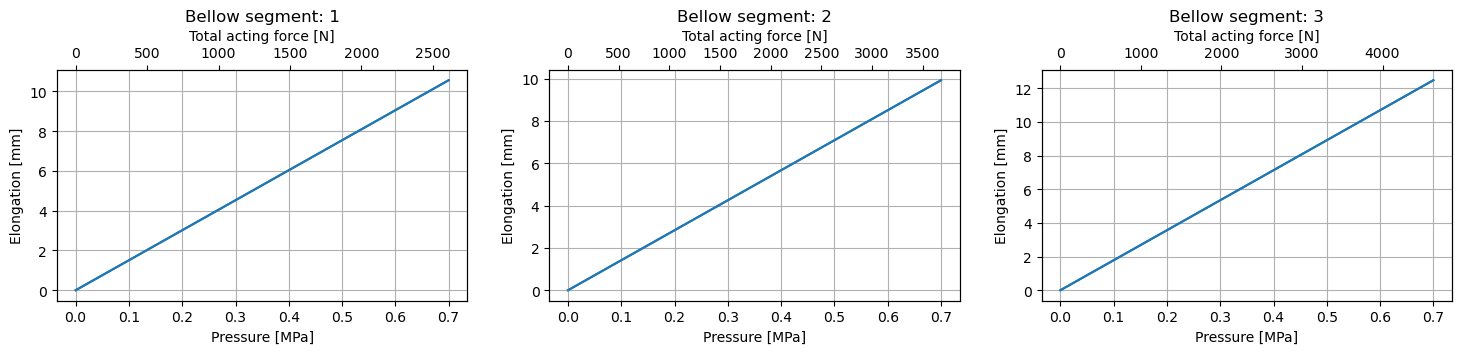

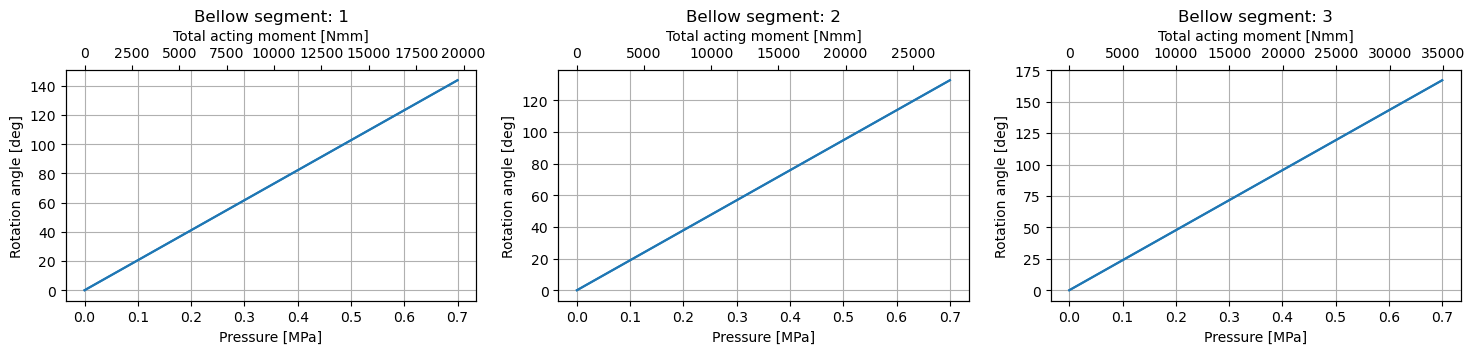

In [8]:
delta_z = F_bellow / Cz[:, np.newaxis] 
# Torsional spring constant - for end moment gamma_pivot * K_theta = c_theta
K = c_theta * E * I_total / L0
print(K)
# Calculate pivot angle
delta_theta_pivot = M_bellow / K[:, np.newaxis]
# Calculate angle displacement
delta_theta_y = delta_theta_pivot * c_theta
# All angular deformations for subsequent segments are culumative sum cross columns
delta_theta_y_cum = np.cumsum(delta_theta_y, axis=0)

# Plot all elongations vs input pressure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))
for i in range(3):
    ax[i].plot(pressure, delta_z[i, :])
    ax[i].set_xlabel('Pressure [MPa]')
    ax[i].set_ylabel('Elongation [mm]')
    ax[i].set_title(f'Bellow segment: {i+1}')
    # Add twin x axis showing input force
    ax2 = ax[i].twiny()
    ax2.plot(F_bellow[i, :], delta_z[i, :])
    ax2.set_xlabel('Total acting force [N]')
    ax[i].grid()

# Plot all rotation angles ve input pressure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))
for i in range(3):
    ax[i].plot(pressure, delta_theta_y[i, :] * 180 / np.pi)
    ax[i].set_xlabel('Pressure [MPa]')
    ax[i].set_ylabel('Rotation angle [deg]')
    ax[i].set_title(f'Bellow segment: {i+1}')
    # Add twin x axis showing imput moment
    ax2 = ax[i].twiny()
    ax2.plot(M_bellow[i, :], delta_theta_y[i, :] * 180 / np.pi)
    ax2.set_xlabel('Total acting moment [Nmm]')
    ax[i].grid()

In [9]:
print(delta_theta_y * 180 / np.pi)
print(delta_theta_y_cum * 180 / np.pi)
print(delta_z)

[[  0.          20.55113321  41.10226643  61.65339964  82.20453286
  102.75566607 123.30679929 143.8579325 ]
 [  0.          18.97081329  37.94162659  56.91243988  75.88325317
   94.85406647 113.82487976 132.79569305]
 [  0.          23.86642093  47.73284186  71.59926279  95.46568371
  119.33210464 143.19852557 167.0649465 ]]
[[  0.          20.55113321  41.10226643  61.65339964  82.20453286
  102.75566607 123.30679929 143.8579325 ]
 [  0.          39.52194651  79.04389302 118.56583953 158.08778603
  197.60973254 237.13167905 276.65362556]
 [  0.          63.38836744 126.77673487 190.16510231 253.55346975
  316.94183719 380.33020462 443.71857206]]
[[ 0.          1.50869736  3.01739472  4.52609207  6.03478943  7.54348679
   9.05218415 10.56088151]
 [ 0.          1.41809106  2.83618212  4.25427317  5.67236423  7.09045529
   8.50854635  9.92663741]
 [ 0.          1.7840436   3.56808721  5.35213081  7.13617441  8.92021802
  10.70426162 12.48830522]]


#### PRB model with elongations and end-moment - fit to absolute xy points

In [381]:
# Resample fem_data using every 10th pressure column and grouping by joint column
# This is done to match the experimental data
fem_data

,time,pressure,joint,resample_u1_start,resample_u1_mid,resample_u1_end,resample_u2_start,resample_u2_mid,resample_u2_end,u1_init_offset_start,...,u1_init_offset_end,L_init,L_arc,R_arc,u1_center_arc,u2_center_arc,theta_arc,theta_arc_start,theta_arc_end,delta_L
0,0.30,0.090,MCP,0.000000,15.311743,30.442612,0.000000,0.411775,0.649642,0.000,...,30.000,30.0,30.450175,1363.408050,44.307827,-1362.687905,0.022334,-0.032504,6.273016,0.450175
1,0.31,0.093,MCP,0.000000,15.324331,30.483414,0.000000,0.406831,0.604733,0.000,...,30.000,30.0,30.490337,1130.316733,37.658602,-1129.689226,0.026975,-0.033323,6.276837,0.490337
2,0.32,0.096,MCP,0.000000,15.337619,30.524283,0.000000,0.400560,0.555250,0.000,...,30.000,30.0,30.530623,958.595933,32.694312,-958.038227,0.031849,-0.034113,6.280922,0.530623
3,0.33,0.099,MCP,0.000000,15.352525,30.567569,0.000000,0.392089,0.497905,0.000,...,30.000,30.0,30.573382,822.801075,28.682037,-822.301009,0.037158,-0.034866,0.002292,0.573382
4,0.34,0.102,MCP,0.000000,15.369631,30.615026,0.000000,0.380990,0.431025,0.000,...,30.000,30.0,30.620419,712.056042,25.329151,-711.605397,0.043003,-0.035579,0.007423,0.620419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,0.96,0.288,DIP,58.102933,51.889008,39.388233,-67.258823,-80.132255,-87.363624,90.267,...,110.667,20.4,29.167114,24.442460,33.945836,-63.534772,1.193297,1.723752,2.917049,8.767114
209,0.97,0.291,DIP,56.859402,50.247022,37.441821,-68.157276,-80.890988,-87.707258,90.267,...,110.667,20.4,29.295991,24.304498,32.944595,-63.822460,1.205373,1.750110,2.955483,8.895991
210,0.98,0.294,DIP,55.589492,48.575378,35.470194,-69.051492,-81.635659,-88.023018,90.267,...,110.667,20.4,29.438375,24.177476,31.922975,-64.107174,1.217595,1.776750,2.994345,9.038375
211,0.99,0.297,DIP,54.293453,46.874206,33.473181,-69.941750,-82.366674,-88.311310,90.267,...,110.667,20.4,29.596091,24.062748,30.880225,-64.388675,1.229955,1.803670,3.033625,9.196091


In [118]:
# Load data
# fem_data = pd.read_csv('kinematics/Hand9DOF/Index/data/FEM_position_data_arc_approx_joint_elongation_angles.csv')
fem_data = pd.read_csv('kinematics/Hand9DOF/Index/data/FEM_position_data_index_arc_approx_joint_elongation_angles_resample.csv')
# fem_data = pd.read_csv('kinematics/Hand9DOF/Index/data/FEM_position_data_little_arc_approx_joint_elongation_angles_resample.csv')
inter_joint_dist_df = pd.read_csv('kinematics/Hand9DOF/Index/data/inter_joint_distance_index.csv')
# inter_joint_dist_df = pd.read_csv('kinematics/Hand9DOF/Index/data/inter_joint_distance_little.csv')
# Length of all three bellow segments in mm
L_init = fem_data['L_init'].unique()
pressure = fem_data['pressure'].unique()  # Internal pressure (MPa)
inter_joint_dist = inter_joint_dist_df['max'].to_numpy()  # Maximum inter-joint distance

# joint_coords_fem = np.stack((
#     np.vstack((
#         fem_data[fem_data['joint'] == 'MCP'][['u1_start', 'u1_end']].to_numpy().T,
#         fem_data[fem_data['joint'] == 'PIP'][['u1_start', 'u1_end']].to_numpy().T,
#         fem_data[fem_data['joint'] == 'DIP'][['u1_start', 'u1_end']].to_numpy().T
#     )),
#     np.vstack((
#         fem_data[fem_data['joint'] == 'MCP'][['u2_start', 'u2_end']].to_numpy().T,
#         fem_data[fem_data['joint'] == 'PIP'][['u2_start', 'u2_end']].to_numpy().T,
#         fem_data[fem_data['joint'] == 'DIP'][['u2_start', 'u2_end']].to_numpy().T
#     ))),
#     axis=2
# )
joint_coords_fem = np.stack((
    np.vstack((
        fem_data[fem_data['joint'] == 'MCP'][['resample_u1_start', 'resample_u1_end']].to_numpy().T,
        fem_data[fem_data['joint'] == 'PIP'][['resample_u1_start', 'resample_u1_end']].to_numpy().T,
        fem_data[fem_data['joint'] == 'DIP'][['resample_u1_start', 'resample_u1_end']].to_numpy().T
    )),
    np.vstack((
        fem_data[fem_data['joint'] == 'MCP'][['resample_u2_start', 'resample_u2_end']].to_numpy().T,
        fem_data[fem_data['joint'] == 'PIP'][['resample_u2_start', 'resample_u2_end']].to_numpy().T,
        fem_data[fem_data['joint'] == 'DIP'][['resample_u2_start', 'resample_u2_end']].to_numpy().T
    ))),
    axis=2
)

E = 27 # Young's modulus for TPU 85A in MPa
# Error less than 0.5% in tip deflection up to angular deflection of theta_0max = 124.4 deg
# Parametric angle coefficient
c_theta = 1.5164
# Diameters in mm - reinforced and unreinforced
d_hole = 6
D_bellow_out = 22
d_bellow_in = 7.85
# Thickness of bottom layer in mm
# t = (2.5 + 4.7) / 2
# t = 2.5
t = np.array([2.5, 2.5, 2.5])

# Remove thickness of the bellow from R_outer, and add it to r_inner (+0.9 due to geometry)
R_outer = 15.5 - 0.8  # Outer diameter of bellow (mm) - 15.5 is from thick element to top
r_inner = d_bellow_in + 0.575  # Inner diameter of bellow (mm)
n_bellow = np.array([7, 5, 5])  # Number of bellows


def compute_joint_coordinates(
    lmbd, gamma, delta_l_theta_modifier, delta_l_n_bellow_modifier, c_theta, 
    quadratic_correction_term, pressure, R_outer, r_inner,
    n_bellow, L_init, E, d_hole, D_bellow_out, d_bellow_in, t
    ):
    # Compute single bellow area, force and moment
    A_bellow, F_bellow, M_bellow = compute_bellow_moment_force(
        p=pressure, R_outer=R_outer, r_inner=r_inner, n_bellow=n_bellow
        )
    # Calculate equivalent diameter
    D_bellow_out_equivalent = lmbd * D_bellow_out + (1 - lmbd) * d_bellow_in
    # Calculate stiffness
    _, _, _, _, _, Cz, Ky = calculate_stiffness_hollow_semicircular_annulus_thick(
        L_init, E, D_bellow_out_equivalent / 2, d_hole / 2, t
        )
    # PRB parameters
    theta_end, joint_end_rel_x, joint_end_rel_y = compute_prb_params_end_moment(
        E_I_div_L=Ky[:, np.newaxis], M_acting=M_bellow, 
        gamma_characteristic_radius_factor=gamma[:, np.newaxis],
        L_initial_length=L_init[:, np.newaxis],
        c_theta_parametric_angle_coefficient=c_theta[:, np.newaxis],
        quadratic_correction_term=quadratic_correction_term[:, np.newaxis]
        )
    # Compute total elongation (axial + bending)
    delta_l = F_bellow / Cz[:, np.newaxis] + (
        theta_end**2 * delta_l_theta_modifier[:, np.newaxis] + 
        n_bellow[:, np.newaxis] * delta_l_n_bellow_modifier[:, np.newaxis]
        )
    # Compute joint coordinates
    # Solve for MCP joint first
    mcp_joint_start_x, mcp_joint_start_y = np.zeros_like(pressure), np.zeros_like(pressure)
    mcp_joint_end_x, mcp_joint_end_y = compute_prb_joint_end_coord(
        x_joint_start=mcp_joint_start_x, y_joint_start=mcp_joint_start_y,
        joint_end_rel_x=joint_end_rel_x[0, :], joint_end_rel_y=joint_end_rel_y[0, :],
        theta_prev_joint_cumulative=0, 
        delta_l_joint_elongation=delta_l[0, :],
        # delta_l_joint_elongation=0,
        theta_joint_cumulative=theta_end[0, :]
        )
    # Solve for PIP joint second
    pip_joint_start_x, pip_joint_start_y = compute_prb_joint_start_coord(
        x_prev_joint_end=mcp_joint_end_x, y_prev_joint_end=mcp_joint_end_y,
        inter_joint_dist=inter_joint_dist[0], theta_prev_joint_cumulative=theta_end[0, :]
        )
    pip_joint_end_x, pip_joint_end_y = compute_prb_joint_end_coord(
        x_joint_start=pip_joint_start_x, y_joint_start=pip_joint_start_y,
        joint_end_rel_x=joint_end_rel_x[1, :], joint_end_rel_y=joint_end_rel_y[1, :],
        theta_prev_joint_cumulative=theta_end[0, :], 
        delta_l_joint_elongation=delta_l[1, :],
        # delta_l_joint_elongation=0,
        theta_joint_cumulative=theta_end[0:2, :].sum(axis=0)
        )
    # Solve for DIP joint last
    dip_joint_start_x, dip_joint_start_y = compute_prb_joint_start_coord(
        x_prev_joint_end=pip_joint_end_x, y_prev_joint_end=pip_joint_end_y,
        inter_joint_dist=inter_joint_dist[1], theta_prev_joint_cumulative=theta_end[0:2, :].sum(axis=0)
        )
    dip_joint_end_x, dip_joint_end_y = compute_prb_joint_end_coord(
        x_joint_start=dip_joint_start_x, y_joint_start=dip_joint_start_y,
        joint_end_rel_x=joint_end_rel_x[2, :], joint_end_rel_y=joint_end_rel_y[2, :],
        theta_prev_joint_cumulative=theta_end[0:2, :].sum(axis=0), 
        delta_l_joint_elongation=delta_l[2, :],
        # delta_l_joint_elongation=0,
        theta_joint_cumulative=theta_end.sum(axis=0)
        )
    # Create 6 x 100 x 2 array of joint coordinates
    # Each row corresponds to one joint, each column to one pressure, each depth to x and y coordinate
    joint_coords = np.stack((
        # X coordinates
        np.vstack((
            mcp_joint_start_x, mcp_joint_end_x, pip_joint_start_x, pip_joint_end_x,
            dip_joint_start_x, dip_joint_end_x)),
        # Y coordinates - sign is inverted due to coordinate system
        -np.vstack((
            mcp_joint_start_y, mcp_joint_end_y, pip_joint_start_y, pip_joint_end_y,
            dip_joint_start_y, dip_joint_end_y)) 
            ),
        axis=2
        )
    return joint_coords, theta_end


def obj_func_single_param(x):
    # print(x)
    lmbd = x[0:3]
    delta_l_modifier = x[3:6]
    delta_l_n_bellow_modifier = x[6:9]
    gamma = x[9:12]
    c_theta = x[12:15]
    quadratic_correction_term = x[15:18]
    joint_coords_prb, theta_end = compute_joint_coordinates(
        lmbd=lmbd, gamma=gamma, delta_l_theta_modifier=delta_l_modifier, 
        delta_l_n_bellow_modifier=delta_l_n_bellow_modifier, c_theta=c_theta,
        quadratic_correction_term=quadratic_correction_term, pressure=pressure,
        R_outer=R_outer, r_inner=r_inner, n_bellow=n_bellow, L_init=L_init, E=E,
        d_hole=d_hole, D_bellow_out=D_bellow_out, d_bellow_in=d_bellow_in, t=t
        )
    # Maximum or mean euclidean to optimize
    return np.mean(np.linalg.norm(joint_coords_fem - joint_coords_prb, axis=2))

In [119]:
# Basin hopping search near optimum point, bounded by max_bin_count +- (approx_max_loc * max_num_bins)
# No local minimization
class BoundsNoLocalMinimization:
    def __init__(self, lower_bounds, upper_bounds):
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        # Storing x and f values for each iteration
        self.x = []
        self.f = []
        self.accepted = []
    
    def no_minimization(self, fun, x0, args, **options):
        # Evaluate function at x0
        fun_res = fun(x0).ravel()
        return OptimizeResult(x=x0, fun=fun_res, success=True, nfev=1)

    def impose_bounds(self, **kwargs):
        # Limit search space 
        x = kwargs["x_new"]
        return np.all((self.lower_bounds <= x) * (x <= self.upper_bounds))

    def store_jumps(self, x, f, accepted):
        # Can return True to terminate optimization early
        self.x.append(x)
        self.f.append(f.ravel())
        self.accepted.append(accepted)
        
class TakeStepRoutine:
    def __init__(self, stepsize):
        self.stepsize = stepsize
        self.rng = np.random.default_rng()
        self.stepsize_hist = []

    def __call__(self, x):
        self.stepsize_hist.append(self.stepsize)
        # Step for lambda
        x[0:3] += self.rng.uniform(-self.stepsize * 2, self.stepsize * 2, size=3)
        # Step for delta_l_theta_modifier
        x[3:6] += self.rng.uniform(-self.stepsize * 10, self.stepsize * 10, size=3)
        # Step for delta_l_n_bellow_modifier
        x[6:9] += self.rng.uniform(-self.stepsize, self.stepsize, size=3)
        # Step for gamma
        x[9:12] += self.rng.uniform(-self.stepsize * 2, self.stepsize * 2, size=3)
        # Step for c_theta
        x[12:15] += self.rng.uniform(-self.stepsize * 6, self.stepsize * 6, size=3)
        # Step for quadratic_correction_term
        x[15:18] += self.rng.uniform(-self.stepsize * 10, self.stepsize * 10, size=3)
        return x

def run_basinhopping_optimization(*args, **kwargs):
    bounds_minimizer = BoundsNoLocalMinimization(
        lower_bounds=np.array([
            0.40, 0.40, 0.40, 
            0.00, 0.00, 0.00,
            0.00, 0.00, 0.00, 
            0.0, 0.0, 0.0,
            1.0, 1.0, 1.0,
            -1.0, -1.0, -1.0
            ]),
        upper_bounds=np.array([
            1.5, 1.5, 1.5,
            15.0, 15.0, 15.0, 
            0.20, 0.20, 0.20,
            1.0, 1.0, 1.0,
            8.0, 8.0, 8.0,
            20.0, 20.0, 20.0
            ])
        )
    take_step_routine = TakeStepRoutine(stepsize=0.01)
    opt_res_bh = scipy.optimize.basinhopping(
        func=obj_func_single_param, 
        # Random initial guess between bounds
        x0=np.random.uniform(bounds_minimizer.lower_bounds, bounds_minimizer.upper_bounds),
        niter=1_000_000, # Number of iterations
        T=0.2,
        take_step=take_step_routine,
        interval=100, # Update stepsize every 200 iterations
        stepwise_factor=0.9, # 90% stepsize adjustment
        target_accept_rate=0.60, # 60% acceptance rate on step taking
        callback=bounds_minimizer.store_jumps,
        accept_test=bounds_minimizer.impose_bounds,
        minimizer_kwargs={'method': bounds_minimizer.no_minimization},
        )
    return opt_res_bh, bounds_minimizer, take_step_routine

with ProcessPoolExecutor(max_workers=4) as executor:
    results_list = list(executor.map(run_basinhopping_optimization, range(4)))

In [122]:
best_results = min(results_list, key=lambda x: x[0].fun)
# Get fun and x for results in list
[(i[0].fun, i[0].x) for i in results_list]
# results_list
best_results[0]
# plt.plot(best_results[1].f)

                        fun: array([1.27941102])
 lowest_optimization_result:      fun: array([1.27941102])
    nfev: 1
 success: True
       x: array([ 1.48968828e+00,  1.15003148e+00,  5.08957799e-01,  9.97644578e+00,
        6.78135325e+00,  9.50498586e+00,  5.51316720e-02,  7.42199215e-03,
        1.70407131e-01,  2.66520997e-01,  6.83726003e-01,  9.89929574e-01,
        1.25169483e+00,  3.15437798e+00,  1.55350062e+00,  1.02545158e+01,
        1.74636701e+01, -3.80488658e-01])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1000001
                        nit: 1000000
                    success: True
                          x: array([ 1.48968828e+00,  1.15003148e+00,  5.08957799e-01,  9.97644578e+00,
        6.78135325e+00,  9.50498586e+00,  5.51316720e-02,  7.42199215e-03,
        1.70407131e-01,  2.66520997e-01,  6.83726003e-01,  9.89929574e-01,
        1.25169483e+

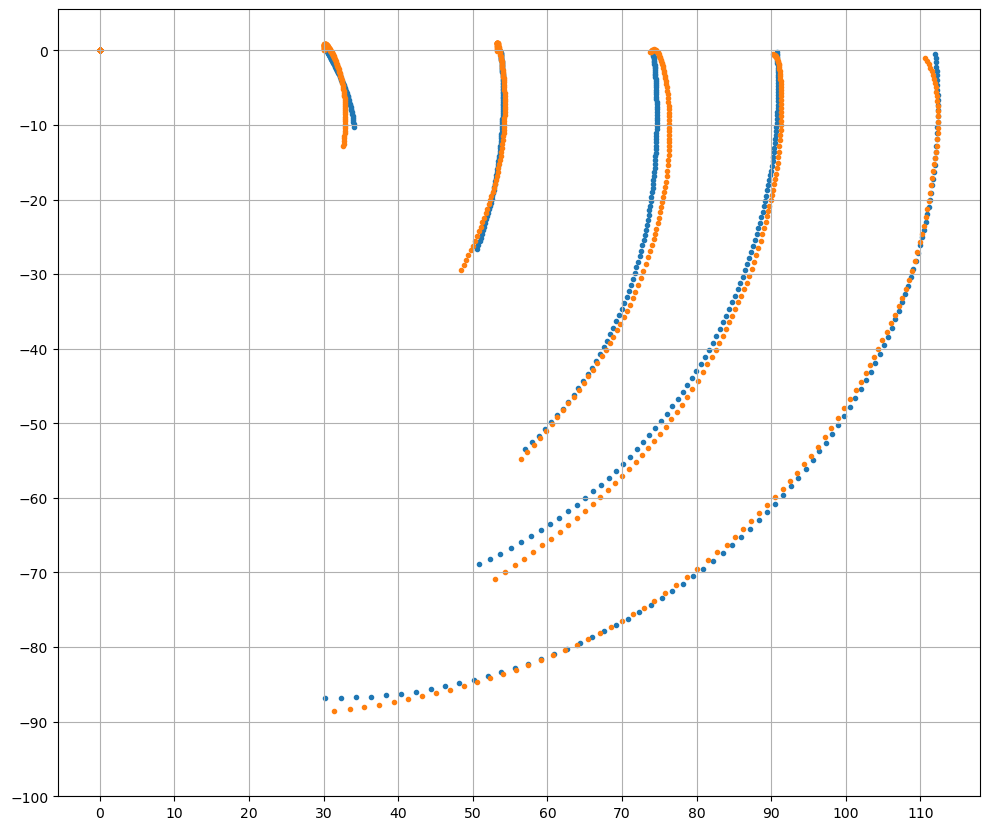

In [125]:
joint_coords, theta_end = compute_joint_coordinates(
    lmbd=best_results[0].x[0:3], 
    delta_l_theta_modifier=best_results[0].x[3:6], 
    delta_l_n_bellow_modifier=best_results[0].x[6:9], 
    gamma=best_results[0].x[9:12],
    c_theta=best_results[0].x[12:15],
    quadratic_correction_term=best_results[0].x[15:18],
    pressure=pressure,
    R_outer=R_outer, r_inner=r_inner, n_bellow=n_bellow, L_init=L_init, E=E, d_hole=d_hole,
    D_bellow_out=D_bellow_out, d_bellow_in=d_bellow_in, t=t
)
# Plot all joint coords as scatterplot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.scatter(joint_coords[:, :, 0], joint_coords[:, :, 1], marker='.')
ax.scatter(joint_coords_fem[:, :, 0], joint_coords_fem[:, :, 1], marker='.')
# Add gridlines at 10 mm intervals
ax.set_xticks(np.arange(0, 120, 10))
ax.set_yticks(np.arange(-100, 10, 10))
ax.grid()
ax.set_aspect('equal')
plt.tight_layout()

In [126]:
pos_data_optim = pd.DataFrame(
    joint_coords.reshape(-1, 2), 
    columns=['u1', 'u2']
    )
# Assign joint names MCP_start, MCP_end, PIP_start, PIP_end, DIP_start, DIP_end to every
# 100 data points and add to pos_data_optim
pos_data_optim['joint'] = np.repeat(
    np.array(['MCP_start', 'MCP_end', 'PIP_start', 'PIP_end', 'DIP_start', 'DIP_end']), 100
    )
# Add pressure column to pos_data_optim by repeating pressure values 6 times
pos_data_optim['pressure'] = np.tile(pressure, 6)
pos_data_optim
# Save optimized position data to csv
# pos_data_optim.to_csv('kinematics/Hand9DOF/Index/data/PRB_position_data_little.csv', index=False)
pos_data_optim.to_csv('kinematics/Hand9DOF/Index/data/PRB_position_data_index.csv', index=False)


In [110]:
pos_data_optim

NameError: name 'pos_data' is not defined

In [395]:
theta_end * 180 / np.pi

array([[ 5.61211543,  5.79918594,  5.98625646,  6.17332697,  6.36039749,
         6.547468  ,  6.73453851,  6.92160903,  7.10867954,  7.29575006,
         7.48282057,  7.66989109,  7.8569616 ,  8.04403211,  8.23110263,
         8.41817314,  8.60524366,  8.79231417,  8.97938469,  9.1664552 ,
         9.35352571,  9.54059623,  9.72766674,  9.91473726, 10.10180777,
        10.28887829, 10.4759488 , 10.66301931, 10.85008983, 11.03716034,
        11.22423086, 11.41130137, 11.59837189, 11.7854424 , 11.97251291,
        12.15958343, 12.34665394, 12.53372446, 12.72079497, 12.90786549,
        13.094936  , 13.28200652, 13.46907703, 13.65614754, 13.84321806,
        14.03028857, 14.21735909, 14.4044296 , 14.59150012, 14.77857063,
        14.96564114, 15.15271166, 15.33978217, 15.52685269, 15.7139232 ,
        15.90099372, 16.08806423, 16.27513474, 16.46220526, 16.64927577,
        16.83634629, 17.0234168 , 17.21048732, 17.39755783, 17.58462834,
        17.77169886, 17.95876937, 18.14583989, 18.3

In [124]:
np.max(np.linalg.norm(joint_coords_fem - joint_coords, axis=2))

3.7991463187144787

In [284]:
np.linalg.norm(joint_coords_fem - joint_coords, axis=2)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [207]:
joint_coords[5, :, :] - joint_coords_fem[5, :, :]

array([[ -0.07229343,  -1.38712505],
       [ -0.24434856,  -2.51100602],
       [ -0.40102333,  -3.5883937 ],
       [ -0.52751928,  -4.60392389],
       [ -0.70604053,  -5.34866881],
       [ -0.93504862,  -5.79456014],
       [ -1.14425854,  -6.13181843],
       [ -1.33994257,  -6.46058339],
       [ -1.54497429,  -6.71065423],
       [ -1.75100446,  -6.89623001],
       [ -1.95430405,  -7.20813997],
       [ -2.16891413,  -7.78317386],
       [ -2.40429584,  -8.58438232],
       [ -2.6568204 ,  -9.57753716],
       [ -2.93638905, -10.84244177],
       [ -3.26131303, -12.4169114 ],
       [ -3.61778358, -14.17246356],
       [ -3.98152193, -15.93801831],
       [ -4.35494929, -17.63382865],
       [ -4.74829686, -19.19399083],
       [ -5.14774584, -20.46951469],
       [ -5.52765745, -21.31787405],
       [ -5.88347296, -21.71425696],
       [ -6.22151368, -21.69723612],
       [ -6.51990107, -21.28185917],
       [ -6.74238671, -20.50627906],
       [ -6.8894584 , -19.50135432],
 